In [1]:
# main function
import numpy as np
import torch
import matplotlib.pyplot as plt

from xopt.mobo import mobo

# test function
from xopt.evaluators import test_TNK


In [2]:
# Get VOCS
VOCS = test_TNK.VOCS

# add reference point
ref = [1.4, 1.4]

print(VOCS)
# Get evaluate function
EVALUATE = test_TNK.evaluate_TNK

# Run
init_x = torch.tensor([[0.9, 0.9], [0.6, 0.6]])
results = mobo(VOCS, EVALUATE, ref = ref,
                                 n_initial_samples=10,
                                 initial_x=None,
                                 use_gpu=False,
                                 n_steps=20, verbose=False)

{'name': 'TNK_test', 'description': 'Constrainted test function TNK. See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf', 'simulation': 'test_TNK', 'variables': {'x1': [0, 3.14159], 'x2': [0, 3.14159]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constraints': {'c1': ['GREATER_THAN', 0], 'c2': ['LESS_THAN', 0.5]}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {'x9': 'x1'}}
n_feas: 1
n_feas: 2
n_feas: 2
n_feas: 3
n_feas: 4
n_feas: 4
n_feas: 5
n_feas: 5
n_feas: 5
n_feas: 6
n_feas: 6
n_feas: 7
n_feas: 8
n_feas: 8
n_feas: 8
n_feas: 8
n_feas: 9
n_feas: 9
n_feas: 10
n_feas: 11


['inputs', 'objectives', 'constraints', 'constraint_status', 'feasibility', 'model']


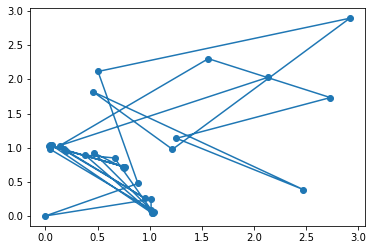

In [3]:
fig, ax = plt.subplots()
print(list(results.keys()))
ax.plot(results['inputs'][:, 0], results['inputs'][:, 1], '-o')

plt.show()